In [1]:
import sqlite3
import matplotlib.pyplot as plt
from html import escape
from IPython.core.display import HTML
from docutils.core import publish_parts

%matplotlib notebook

In [2]:
with open('README.rst') as readme:
    doc = publish_parts(readme.read(), writer_name='html')
HTML(doc['html_body'])

Name,Type,Description
compressor,TEXT,The name of the compressor
Name,Type,Description
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with
Name,Type,Description
machine,TEXT,The label provided on by --machine on the command line
arch,TEXT,The dpkg architecture of the machine
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with
succeeded,INTEGER,"1 if the compression run succeeded, and 0 if it failed"


In [3]:
conn = sqlite3.connect('compression.db')

In [4]:
def show_query(sql):
    cur = conn.execute(sql)
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header).title())}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>"""

### Combinations tested

A list of all the machines (and architectures) tested:

In [5]:
HTML(show_query("""
SELECT DISTINCT machine, arch
FROM results
"""))

Machine,Arch
AMD Opteron,amd64
AMD Ryzen,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2,armhf


A list of all the compressors and options tested:

In [19]:
HTML(show_query("""
SELECT compressor, GROUP_CONCAT(options) AS options
FROM options
GROUP BY compressor
ORDER BY compressor
"""))

Compressor,Options
gzip,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lz4,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-e -0,-e -1,-e -2,-e -3,-e -4,-e -5,-e -6,-e -7,-e -8,-e -9"
zstd,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9,-T0 -1,-T0 -10,-T0 -11,-T0 -12,-T0 -13,-T0 -14,-T0 -15,-T0 -16,-T0 -17,-T0 -18,-T0 -19,-T0 -2,-T0 -3,-T0 -4,-T0 -5,-T0 -6,-T0 -7,-T0 -8,-T0 -9"


The ``-e`` option for ``xz`` enables "extreme" (!) compression, whilst the ``-T0`` option for ``zstd`` enables multi-threaded operation.

### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [6]:
HTML(show_query("""
SELECT machine, arch, compressor, options
FROM results
WHERE succeeded = 0
"""))

Machine,Arch,Compressor,Options
Pi Zero 2,armhf,xz,-8
Pi Zero 2,armhf,xz,-9
Pi Zero 2,armhf,xz,-e -8
Pi Zero 2,armhf,xz,-e -9
Pi Zero 2,armhf,zstd,-T0 -14
Pi Zero 2,armhf,zstd,-T0 -15
Pi Zero 2,armhf,zstd,-T0 -19


From the table above we can see that only the Pi Zero 2 (with 512MB of RAM) has an issue, and that only the more aggressive options of ``xz`` and ``zstd`` cause a direct failure.

However, it's worth bearing in mind that these tests were run on otherwise idle and unloaded systems. We should strive to be as minimal as possible in our memory usage so as not to pressure concurrent services into OOM failure.

On the Pi Zero 2 (and 3A+) with the arm64 architecture, the typical amount of RAM available at runtime with all "default" services loaded (systemd et al), and with the typical firmware stack loaded (which allocates 64MB to the GPU), is only around 200MB. Anything that takes >20MB of resident memory is therefore eating at least 10% of the RAM available, and could be considered a "bad idea":

In [22]:
HTML(show_query("""
WITH t AS (
    SELECT
        machine, arch, compressor, options,
        ROW_NUMBER() OVER (PARTITION BY machine, arch, compressor ORDER BY max_resident)
    FROM results
    WHERE succeeded = 1
    AND max_resident > 20000
)
SELECT * FROM t
"""))

Machine,Arch,Compressor,Options,"Row_Number() Over (Partition By Machine, Arch, Compressor Order By Max_Resident)"
AMD Opteron,amd64,xz,-e -2,1
AMD Opteron,amd64,xz,-3,2
AMD Opteron,amd64,xz,-e -4,3
AMD Opteron,amd64,xz,-e -3,4
AMD Opteron,amd64,xz,-4,5
AMD Opteron,amd64,xz,-6,6
AMD Opteron,amd64,xz,-e -5,7
AMD Opteron,amd64,xz,-5,8
AMD Opteron,amd64,xz,-e -6,9
AMD Opteron,amd64,xz,-7,10


### Silly combinations

Show all compressor+option combinations that took more than 20 seconds to produce a result

In [7]:
HTML(show_query("""
SELECT machine, compressor, options, elapsed
FROM results
WHERE elapsed > 20
ORDER BY elapsed DESC
"""))

Machine,Compressor,Options,Elapsed
Pi 4 8GB,xz,-e -9,311.71
Pi 4 8GB,xz,-e -8,288.21
Pi 4 8GB,xz,-e -7,274.09
Pi 4 8GB,xz,-e -6,256.3
Pi 4 8GB,xz,-e -4,239.38
Pi 4 8GB,xz,-e -5,237.94
Pi 4 8GB,xz,-9,237.6
Pi 4 8GB,xz,-e -2,226.93
Pi 4 8GB,xz,-e -3,224.09
Pi 4 8GB,xz,-8,221.13


In [12]:
compressors = [
    row[0]
    for row in conn.execute("SELECT compressor FROM compressors")
]
data = {
    compressor:
    list(conn.execute("""
        SELECT elapsed, ratio
        FROM results
        WHERE compressor = ?
        AND succeeded = 1
        AND elapsed <= 20
    """, (compressor,)))
    for compressor in compressors
}
data = {
    compressor: {
        'elapsed': [elapsed for elapsed, ratio in results],
        'ratio': [ratio for elapsed, ratio in results],
    }
    for compressor, results in data.items()
}

<IPython.core.display.Javascript object>


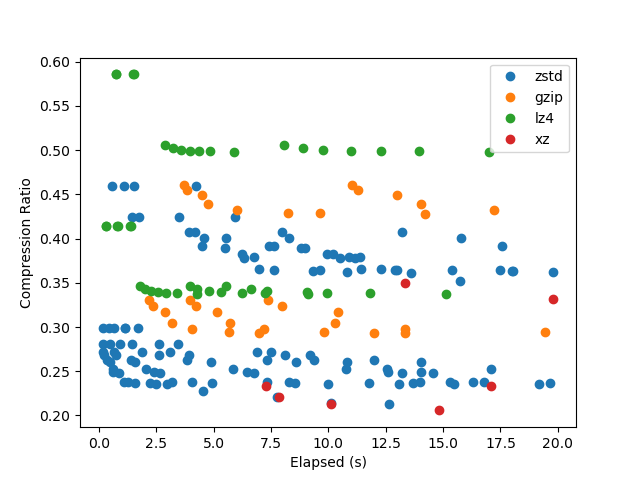

In [13]:
for compressor, results in data.items():
    plt.plot('elapsed', 'ratio', data=results,
             label=compressor, marker='o', linestyle='none')
plt.xlabel('Elapsed (s)')
plt.ylabel('Compression Ratio')
plt.legend()